In [82]:
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

In [87]:
def det_3x3(a, b, c):
    return (c[1]-b[1])*(b[0]-a[0])-(c[0]-b[0])*(b[1]-a[1])


def generate_uniform_points(left=-100, right=100, n=100, prec = 3):
    random.seed()
    points = set()
    for i in range(n):
        while True:
            x = round(random.uniform(left,right), prec)
            y = round(random.uniform(left,right), prec)
            new_point = (x,y)
            if new_point not in points:
                points.add(new_point)
                break
    return list(points)



def merge(A, B, a, b):
    print("merge:", a, len(A), b, len(B))
    n, m, hull = len(A), len(B), []
    for i in range(a+1):
        hull.append(A[i])
    for j in range(b, m, 1):
        hull.append(B[j])
    return hull


def check(A, B, mid_a, mid_b, p = 1):
    n, m = len(A), len(B)
    if(mid_a >= 1 and det_3x3(A[mid_a], B[mid_b], A[mid_a - 1]) * p > 0):
        return False
    if(mid_a <= n-2 and det_3x3(A[mid_a], B[mid_b], A[mid_a + 1]) * p > 0):
        return False
    if(mid_b >= 1 and det_3x3(A[mid_a], B[mid_b], B[mid_b - 1]) * p > 0):
        return False
    if(mid_b <= m-2 and det_3x3(A[mid_a], B[mid_b], B[mid_b + 1]) * p > 0):
        return False
    return True


def upper_circle_points(O, R, n, k, prec):
    points=[]
    step = 1/n
    for i in range (n//k):
        t = step * i
        x = O[0] + round(R*np.cos(t*np.pi*2), prec)
        y = O[1] + round(R*np.sin(t*np.pi*2), prec)
        points.append((x,y))
    return points


def lower_circle_points(O, R, n, k, prec):
    points=[]
    step = 1/n
    for i in range (((k-1) * n)//k, n):
        t = step * i
        x = O[0] + round(R*np.cos(t*np.pi*2), prec)
        y = O[1] + round(R*np.sin(t*np.pi*2), prec)
        points.append((x,y))
    return points

def add_perimeter(hull, Visual, col):
    n = len(hull)
    for i in range(n-1):
        Visual.add_line_segment([(hull[i], hull[i+1])], color = col)
    Visual.add_line_segment([(hull[-1], hull[0])], color = col)
    return

def concat_arr(arr1, arr2):
    res = []
    for i in range(len(arr1)):
        res.append(arr1[i])
    arr2.reverse()
    for j in range(len(arr2)):
        res.append(arr2[j])
    return res

def classify(hull):
    n = len(hull)
    A, B = hull[0], hull[-1]
    up, down = [A], []
    for i in range(1, n-1):
        orient = det_3x3(A, B, hull[i])
        if(orient > 0):
            up.append(hull[i])
        else:
            down.append(hull[i])
    down.append(B)
    return up, down

def split(hull):
    n, ind = len(hull), -1
    for i in range(1, n, 1):
        if(hull[i-1] > hull[i]):
            ind = i-1
            break
    l, r = hull[:ind], hull[ind:]
    return l, r

def BruteHull(points):
    n, hull = len(points), []
    vis = [0] * n
    for i in range(n):
        for j in range(i+1, n, 1):
            inside, outside = 0, 0
            for k in range(n):
                orient = det_3x3(points[i], points[j], points[k]) 
                if(k == j or k == i or orient == 0):
                    inside, outside = inside + 1, outside + 1
                elif(orient < 0):
                    outside += 1
                else:
                    inside += 1
            if(inside == n or outside == n):
                vis[i], vis[j] = 1, 1
                
    for i in range(n):
        if(vis[i]):
            hull.append(points[i])
    up, down = classify(hull)
    new_hull = concat_arr(up, down)
    return hull
        

In [113]:
def convert(points):
    new_points, n = [], len(points)
    for i in range(n):
        new_points.append((points[i], i))
    return new_points


def bin_search(A, B, p = 1):
    print("parametr:", p)
    n, m = len(A), len(B)
    left_a, right_a, left_b, right_b, mid_a, mid_b = 0, n-1, 0, m-1, -1, -1
    mid_a = (left_a + right_a)//2
    while(True):
        left_b, right_b = 0, m-1
        while(True):
            mid_b, flag = (left_b + right_b)//2, True
            print("B:", left_b, mid_b, right_b, "mid_a:", mid_a)
            if(left_b == right_b):
                break
            if(mid_b >= 1):
                print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_b-1:", mid_b - 1)
                orient = det_3x3(A[mid_a], B[mid_b], B[mid_b-1])
                print(round(orient, 2))
                if(orient * p > 0):
                    right_b, flag = mid_b-1, False
            if(mid_b <= m-2):
                print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_b+1:", mid_b + 1)
                orient = det_3x3(A[mid_a], B[mid_b], B[mid_b+1])
                print(round(orient, 2))
                if(orient * p > 0):
                    left_b, flag = mid_b+1, False
            #print("B:", flag)
            if(flag):
                break
        left_a, right_a = 0, n-1
        while(True):
            mid_a, flag = (left_a + right_a)//2, True
            if(left_a == right_a):
                break
            print("A:", left_a, mid_a, right_a, "mid_b:", mid_b)
            if(mid_a >= 1):
                print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_a-1", mid_a - 1)
                orient = det_3x3(A[mid_a], B[mid_b], A[mid_a - 1])
                print(round(orient, 2))
                if(orient*p > 0):
                    right_a, flag = mid_a-1, False
            if(mid_a <= n-2):
                print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_a+1:", mid_a + 1)
                orient = det_3x3(A[mid_a], B[mid_b], A[mid_a + 1])
                print(round(orient, 2))
                if(orient*p > 0):
                    left_a, flag = mid_a+1, False
            if(flag):
                break  
        #print("compare", mid_a, mid_b)    
        if(check(A, B, mid_a, mid_b, p)):
            print(mid_a, mid_b)
            return mid_a, mid_b
      

      
global col, colors
col = 0
colors = ["cyan", "green", "blue", "red", "grey", "brown", "black", "purple", "orange"]

In [114]:
def Divide_Conquer(points, Visual):
    global col, colors
    n = len(points)
    print(n)
    if(n <= 5):
        hull = BruteHull(points)
        Visual.add_point(hull, color = colors[col] )
        Visual.show()
        col = (col + 1) % 9
        return hull
    mid = n//2
    A = Divide_Conquer(points[0:mid], Visual)
    B = Divide_Conquer(points[mid:], Visual)
    A_up, A_down = split(A)
    B_up, B_down = split(B)
    
    
    Visual.add_point(A_up, color = colors[col])
    col = (col + 1) % 9
    Visual.add_point(A_down, color = colors[col])
    col = (col + 1) % 9
    Visual.add_point(B_up, color = colors[col])
    col = (col+1)%9
    Visual.add_point(B_down, color = colors[col])
    col = (col+1) % 9
    Visual.show()
    
    
    ind_a_up, ind_b_up = bin_search(A_up, B_up)
    up_total = merge(A_up, B_up, ind_a_up, ind_b_up)
    ind_a_down, ind_b_down = bin_search(A_down, B_down, -1)
    down_total = merge(A_down, B_down, ind_a_down, ind_b_down)
    res = concat_arr(up_total, down_total)
    return res
    

10
5
5
parametr: 1
B: 0 1 3 mid_a: 0
orient: mid_a: 0 mid_b: 1 mid_b-1: 0
-108.19
orient: mid_a: 0 mid_b: 1 mid_b+1: 2
20.08
B: 2 2 3 mid_a: 0
orient: mid_a: 0 mid_b: 2 mid_b-1: 1
-20.08
orient: mid_a: 0 mid_b: 2 mid_b+1: 3
-157.41
A: 0 0 1 mid_b: 2
orient: mid_a: 0 mid_b: 2 mid_a+1: 1
-124.32
0 2
merge: 0 2 2 4
parametr: -1
B: 0 0 0 mid_a: 0
0 0
merge: 0 1 0 1


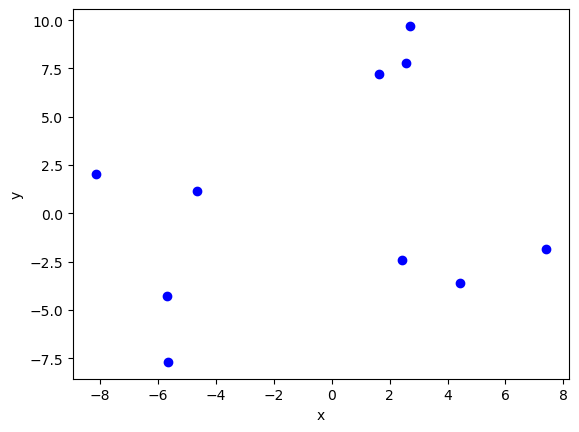

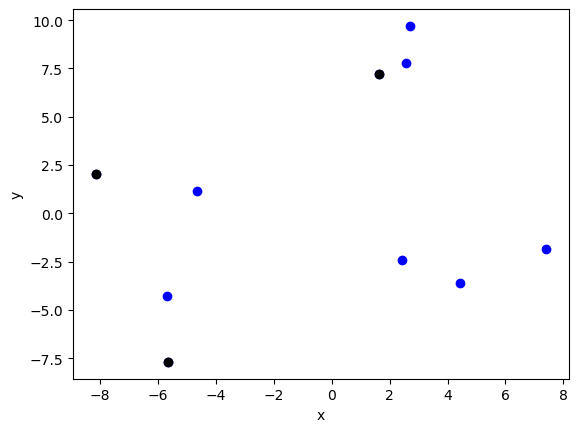

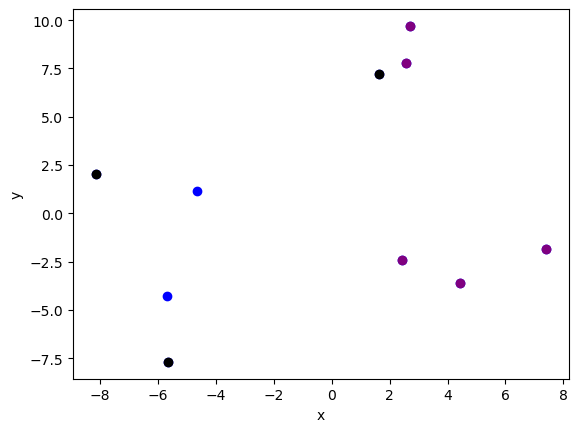

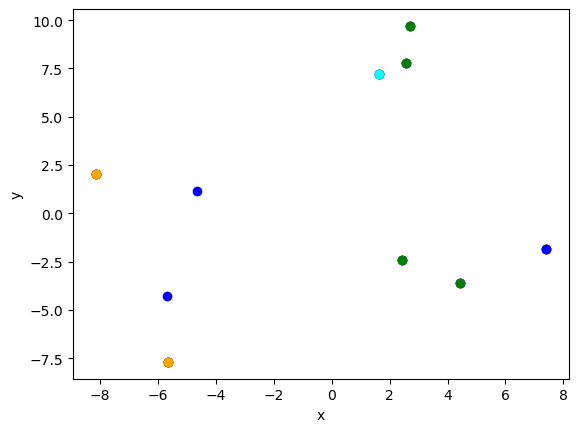

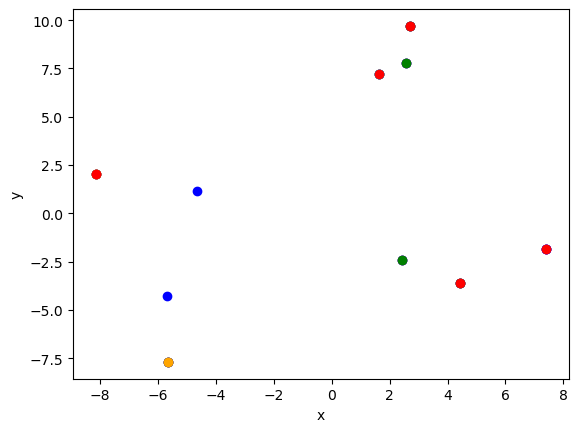

In [116]:
#A_upper = upper_circle_points((0, 0), 15, 120, 2, 2)
#B_upper = upper_circle_points((60, 0), 40, 100, 2, 2)
#A_lower = lower_circle_points((0, 0), 15, 26, 2, 2)
#B_lower = lower_circle_points((60, 0), 40, 28, 2, 2)
#A_upper.reverse()
#B_upper.reverse()
#print(A_lower)
#print(B_lower)
Z = """
cipa1 = upper_circle_points((0, 0), 15, 30, 1, 2)
cipa2 = upper_circle_points((60, 10), 30, 40, 1, 2)
cipa1.sort()
cipa2.sort()
vis6 = Visualizer()
vis6.add_point(cipa1, color = "blue")
vis6.add_point(cipa2, color = "red")
vis6.show()
cipa1_up, cipa1_down = classify(cipa1)
cipa2_up, cipa2_down = classify(cipa2)
vis6.add_point(cipa1_up, color = "green")
vis6.add_point(cipa1_down, color = "purple")
vis6.add_point(cipa2_up, color = "blue")
vis6.add_point(cipa2_down, color = "grey")
vis6.show()
x_up, y_up = bin_search(cipa1_up, cipa2_up)
vis6.add_line([(cipa1_up[x_up], cipa2_up[y_up])], color = "red")
vis6.show()
x_down, y_down = bin_search(cipa1_down, cipa2_down, -1)
vis6.add_line([(cipa1_down[x_down], cipa2_down[y_down])], color = "red")
vis6.show()
convex_up = merge(cipa1_up, cipa2_up, x_up, y_up)
convex_down = merge(cipa1_down, cipa2_down, x_down, y_down)
vis6.add_point(convex_up, color = "red")
vis6.add_point(convex_down, color = "cyan")
vis6.show()


vis7 = Visualizer()
convex_total = concat_arr(convex_up, convex_down)
vis7.add_point(cipa1, color = "blue")
vis7.add_point(cipa2, color = "blue")
vis7.add_point(convex_total, color = "red")
add_perimeter(convex_total, vis7, "red")
vis7.add_point([convex_up[0]], color = "cyan")
vis7.add_point([convex_down[-1]], color = "pink")
size = len(convex_total)
maxi = (-float('inf'), -float('inf'))
for i in range(1, size, 1):
    if(convex_total[i-1] > convex_total[i]):
        maxi = convex_total[i-1]
        break
vis7.add_point([maxi], color = "green")
vis7.show()
"""

vis8 = Visualizer()
test = generate_uniform_points(-10, 10, 10)
test.sort()
vis8.add_point(test, color = "blue")
vis8.show()
result = Divide_Conquer(test, vis8)
vis8.add_point(result, color = "red")
vis8.show()


"""
vis3 = Visualizer()
chuj = generate_uniform_points(-10, 10, 20)
chuj.sort()
print(chuj)
vis3.add_point(chuj, color = "blue")
brute_chuj = BruteHull(chuj)
vis3.add_point(brute_chuj, color = "red")
vis3.show()
up, down = classify(brute_chuj)
print(down)
vis3.add_point(up, color = "green")
vis3.add_point(down, color = "purple")
vis3.show()
down.reverse()
for i in range(len(down)):
    up.append(down[i])
add_perimeter(up, vis3, "red")
vis3.show()
"""
X = """
vis4 = Visualizer()
dupsko = generate_uniform_points(-10, 10, 40)
dupsko.sort()
print(dupsko)
vis4.add_point(dupsko, color = "blue")
vis4.show()
wyn = Divide_Conquer(dupsko)
vis4.add_point(wyn, color = "red")
vis4.show

"""
Y = """
vis2 = Visualizer()
vis2.add_point(A_lower, color = "red")
vis2.add_point(B_lower, color = "blue")
vis2.show()
x1, y1 = bin_search(A_lower, B_lower, -1)
vis2.add_line([(A_lower[x1], B_lower[y1])], color = "green")
vis2.show()

vis5 = Visualizer()
vis5.add_point(A_lower, color = "red")
vis5.add_point(B_lower, color = "blue")
convex = merge(A_lower, B_lower, x1, y1)
vis5.add_point(convex, color = "green")
add_perimeter(convex, vis5, "green")
vis5.show()

#vis1 = Visualizer()
#vis1.add_point(A_upper, color = "red")
#vis1.add_point(B_upper, color = "blue")
#vis1.show()
#x, y = bin_search(A_upper, B_upper)
#vis1.add_line_segment([(A_upper[x], B_upper[y])], color = "green")
#vis1.show()

"""

